# Test Dataloader

In [1]:
from utils.data import build_dataset,build_xview_dataset, unwrap_collate_fn
from attrdict import AttrDict
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from utils.fcos import fcos_resnet50_fpn
import torch

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_DATA_DIR='determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/'

dataset, num_classes = build_xview_dataset(image_set='val',args=AttrDict({
                                                'data_dir':TRAIN_DATA_DIR,
                                                'backend':'aws',
                                                'masks': None,
                                                }))

PATHS:  {'train': ('determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/', '/tmp/train_sliced_no_neg/train_300_02_1k.json'), 'val': ('determined-ai-xview-coco-dataset/val_sliced_no_neg/val_images_300_02/', '/tmp/val_sliced_no_neg/val_300_02_1k.json')}
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [3]:
img, ann = dataset[2]
print(ann)
print(img.shape)
np.array(img, dtype=np.uint8).transpose(1,2,0).dtype

{'boxes': tensor([[ 62., 191., 169., 285.],
        [ 79., 107., 180., 200.]]), 'labels': tensor([53, 48]), 'image_id': tensor([3]), 'area': tensor([10058,  9393]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([300, 300]), 'size': tensor([300, 300])}
torch.Size([3, 300, 300])


dtype('uint8')

62.0 191.0 169.0 285.0
79.0 107.0 180.0 200.0


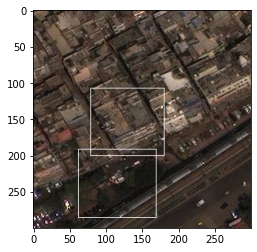

In [4]:
img = Image.fromarray(np.array(img*255, dtype=np.uint8).transpose(1,2,0))
draw = ImageDraw.Draw(img)
for a in ann['boxes']:
    x,y,x2,y2 = a.numpy()
    print( x,y,x2,y2)
    draw.rectangle([x,y,x2,y2])
    
plt.imshow(np.array(img)/255.)

In [5]:
# Load Model

In [6]:
model = fcos_resnet50_fpn(pretrained=False,num_classes=61)
model.load_state_dict(torch.load('model.pth').state_dict())
_=model.eval()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
def collate_fn(batch):
    return tuple(list(zip(*batch)))
data_loader_test = torch.utils.data.DataLoader(
        dataset, batch_size=1, sampler=None, num_workers=0, collate_fn=collate_fn)

In [8]:
images_t, targets_t= list(data_loader_test)[0]

In [9]:
images_t[0].shape

torch.Size([3, 300, 300])

In [10]:
# from time import time
cpu_device = torch.device('cpu')
_,outputs = model(images_t)

# print(type(outputs[0]))
# print(outputs)
outputss = []
for t in outputs:
    outputss.append({k: v.to(cpu_device) for k, v in t.items()})
# model_time = time.time() - model_time
res = {target["image_id"].item(): output for target, output in zip(targets_t, outputss)}

In [11]:

from torchvision.transforms import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)
# inv_tensor = inv_normalize(tensor)

inv_tensor = inv_normalize(images_t[0].clone())

float32 0.50823957 129.60109


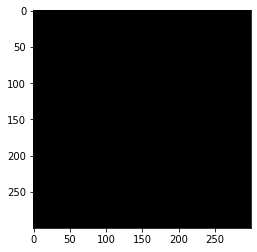

In [12]:
i_test = (inv_tensor.permute((1,2,0))).numpy()
print(i_test.dtype, i_test.mean(), (i_test*255.).mean())
plt.imshow(i_test.astype(np.int32))

0.5061119116476864


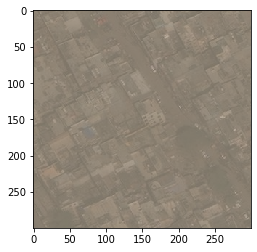

In [23]:
npimg = images_t[0].clone().numpy()
npimg = np.transpose(npimg, (1,2,0))
npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
print((npimg).mean())
plt.imshow(npimg, interpolation='nearest')

In [ ]:
# img = Image.fromarray(np.array(img*255, dtype=np.uint8).transpose(1,2,0))
# draw = ImageDraw.Draw(img)
# for a in ann['boxes']:
#     x,y,x2,y2 = a.numpy()
#     print( x,y,x2,y2)
#     draw.rectangle([x,y,x2,y2])
    
# plt.imshow(img)

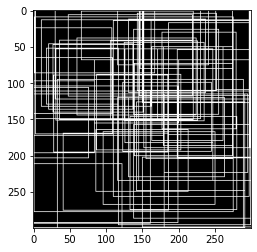

In [14]:
img = Image.fromarray((inv_tensor.permute((1,2,0))).numpy().astype(np.uint8))
draw = ImageDraw.Draw(img)
for b,s in zip(res[1]['boxes'],res[1]['scores']):
    # print(b.detach().numpy(), s.detach().numpy())
    x,y,x2,y2 = b.detach().numpy()
    # print( x,y,x2,y2)
    draw.rectangle([x,y,x2,y2])
    
plt.imshow(img)

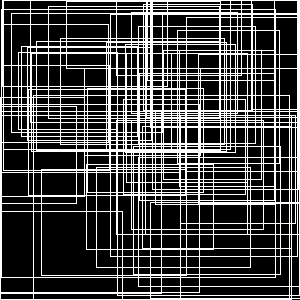

In [15]:
img

In [16]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform

In [17]:
transform = GeneralizedRCNNTransform(800, 1333, image_mean, image_std, **kwargs)

NameError: name 'image_mean' is not defined